# Real-time $R_t$ computation on Italian COVID-19 data, by Stefano Terna$^1$

## Notebook on the computeation of $R_t$ by date of hospitalization

$^1$ PhD String Theory, [tomorrowdata.io](https://tomorrowdata.io) CEO

## Citations

1. Tikhonov regularization, [Wikipedia](https://en.wikipedia.org/wiki/Tikhonov_regularization)
2. Time Series Seasonal Adjustment Using Regularized Singular Value Decomposition by Wei Lin, Jianhua Huang (Texas A&M University), Tucker Mcelroy (U.S. Census Bureau), [paper](https://www.researchgate.net/publication/327256122_Time_Series_Seasonal_Adjustment_Using_Regularized_Singular_Value_Decomposition)
3. Task force COVID-19 del Dipartimento Malattie Infettive e Servizio di Informatica, Istituto Superiore di Sanità. Epidemia COVID-19, Aggiornamento nazionale: 18 agosto 2020
4. Dati COVID-19 Italia, Protezione Civile, [github](https://github.com/pcm-dpc/COVID-19)

In [2]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../../')

In [3]:
import os
import locale
locale.setlocale(locale.LC_TIME, "it_IT.UTF8")

from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error
import pymc3 as pm

from covid19_pytoolbox.settings import BASE_DATA_PATH, BASE_IMAGES_PATH
from covid19_pytoolbox import plotting
from covid19_pytoolbox.italy.data import ISS
from covid19_pytoolbox.italy.data import DPC
from covid19_pytoolbox.smoothing.seasonalRSVD.LogRSVD import LogSeasonalRegularizer
from covid19_pytoolbox.smoothing.tikhonovreg import TikhonovRegularization
from covid19_pytoolbox.modeling.datarevision.seasonal import draw_expanded_series, smooth_and_drop
from covid19_pytoolbox.modeling.Rt.bayesian import MCMC_sample
from covid19_pytoolbox.utils import smape, padnan

BASE_DATA_PATH='../../data'
BASE_IMAGES_PATH='../../images'

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Rt gamma parameters:

In [4]:
alpha = 1.87
beta = 0.28

ALPHA=100.

# Nuovi ospedalizzati

The data from Protezione Civile provide us with the total count of hospitalized people for every single day. 

To be able to compute an $R_t$ index based on the hospitalization date, we need the new hospitalized people at each time $t$, which can be intepreted as a measure of the infected people.

### How can we obtain the new hospitalized for each $t$, given that we know the total count of them for $t$?

Given that:
- $TH(t)$ is the total count of hospitalized at time $t$
- $NH(t)$ is the count of new hospitalized at time $t$
- $NRR(t)$ is the count of new recovered and released from hostpitals at time $t$
- $NDT(t)$ is the count of new deaths at time $t$

we can compute the total count of hospitalized today, based on the total hospitalized yesterday, the released and the deaths:

$$TH(t) = TH(t-1) + NH(t) - NRR(t) - NDT(t)$$


Or, solving for $NH$:
$$NH(t) = TH(t) - TH(t-1) + NRR(t) + NDT(t)$$

For recovered-released and deaths we have the cumulative values over time:
- $CRR(t)$ is the cumulative count of recovered and released from hostpitals from the beginning of the epidemic to time $t$
- $CDT(t)$ is the cumulative count of deaths from the beginning of the epidemic to time $t$

So we can rewrite $NRR$ and $NDT$ in terms of their cumulative values:
- $NRR(t) = CRR(t) - CRR(t-1)$
- $NDT(t) = CDT(t) - CDT(t-1)$

The new hospitalized then become:
$$NH(t) = TH(t) + CRR(t) + CDT(t) - \left[TH(t-1) + CRR(t-1) + CDT(t-1)\right]$$

Defining the cumulative hospitalized as:
$$CH(t) = TH(t) + CRR(t) + CDT(t)$$

we finally have:
$$NH(t) = CH(t) - CH(t-1)$$

## Load DPC data, smooth them and compute naive Rt

In [5]:
DPC_data = DPC.load_daily_cases_from_github()
TIMESTEPS, FIRST_CASI_SOSP_DIAGNOSTICO = DPC.preprocess(DPC_data)
DPC.compute_first_diffs(DPC_data)
regularizer = TikhonovRegularization(timesteps=TIMESTEPS, alpha=ALPHA)
DPC.tikhonov_smooth_differentiate(DPC_data, regularizer)
DPC.bulk_compute_naive_Rt(DPC_data, alpha=alpha, beta = beta)

{   'deceduti_giornalieri': 'deceduti',
    'dimessi_guariti_giornalieri': 'dimessi_guariti',
    'nuovi_casi_da_screening': 'casi_da_screening',
    'nuovi_casi_da_sospetto_diagnostico': 'casi_da_sospetto_diagnostico',
    'nuovi_ospedalizzati': 'hospitalized_cumulative',
    'tamponi_giornalieri': 'tamponi'}
{   'deceduti_giornalieri_smoothed': 'deceduti',
    'dimessi_guariti_giornalieri_smoothed': 'dimessi_guariti',
    'nuovi_casi_da_screening_smoothed': 'casi_da_screening',
    'nuovi_casi_da_sospetto_diagnostico_smoothed': 'casi_da_sospetto_diagnostico',
    'nuovi_ospedalizzati_smoothed': 'hospitalized_cumulative',
    'nuovi_positivi_smoothed': 'totale_casi',
    'tamponi_giornalieri_smoothed': 'tamponi'}
tamponi_giornalieri_smoothed - TIC R2: 0.9999954518672743
dimessi_guariti_giornalieri_smoothed - TIC R2: 0.9999954165010781
deceduti_giornalieri_smoothed - TIC R2: 0.9999969970929465
nuovi_positivi_smoothed - TIC R2: 0.9999972078110992
nuovi_casi_da_sospetto_diagnostico_smoot

# Use RSVD: Regularized Singular Value Decomposition

In [6]:
DPC.RSVD_smooth_data(DPC_data, alpha=alpha, beta=beta, difference_degree=2, trend_alpha=ALPHA)

['nuovi_positivi', 'tamponi_giornalieri', 'nuovi_ospedalizzati']
nuovi_positivi_deseason
info_cri:  -2.323280091499613
info_cri:  -1.6655788331697683
TIC R2: 0.9947418328956792
patterns: 1
(   -5.871708039692698,
    3.2287489593078545e-07,
    18,
    420,
    {   '1%': -3.4460159927788574,
        '10%': -2.570448781179138,
        '5%': -2.868446209372638},
    -215.77393415834854)
new columns generated:
[   'nuovi_positivi_deseason',
    'nuovi_positivi_deseason_seasonality',
    'nuovi_positivi_deseason_smoothed',
    'nuovi_positivi_deseason_residuals',
    'nuovi_positivi_deseason_relative_residuals',
    'nuovi_positivi_deseason_smoothed_Rt']
tamponi_giornalieri_deseason
info_cri:  -2.853266784185141
info_cri:  -2.105144994587022
TIC R2: 0.9870874177333807
patterns: 1
(   -6.7167759182017726,
    3.5655319191693213e-09,
    18,
    420,
    {   '1%': -3.4460159927788574,
        '10%': -2.570448781179138,
        '5%': -2.868446209372638},
    -351.3060319598201)
new columns ge

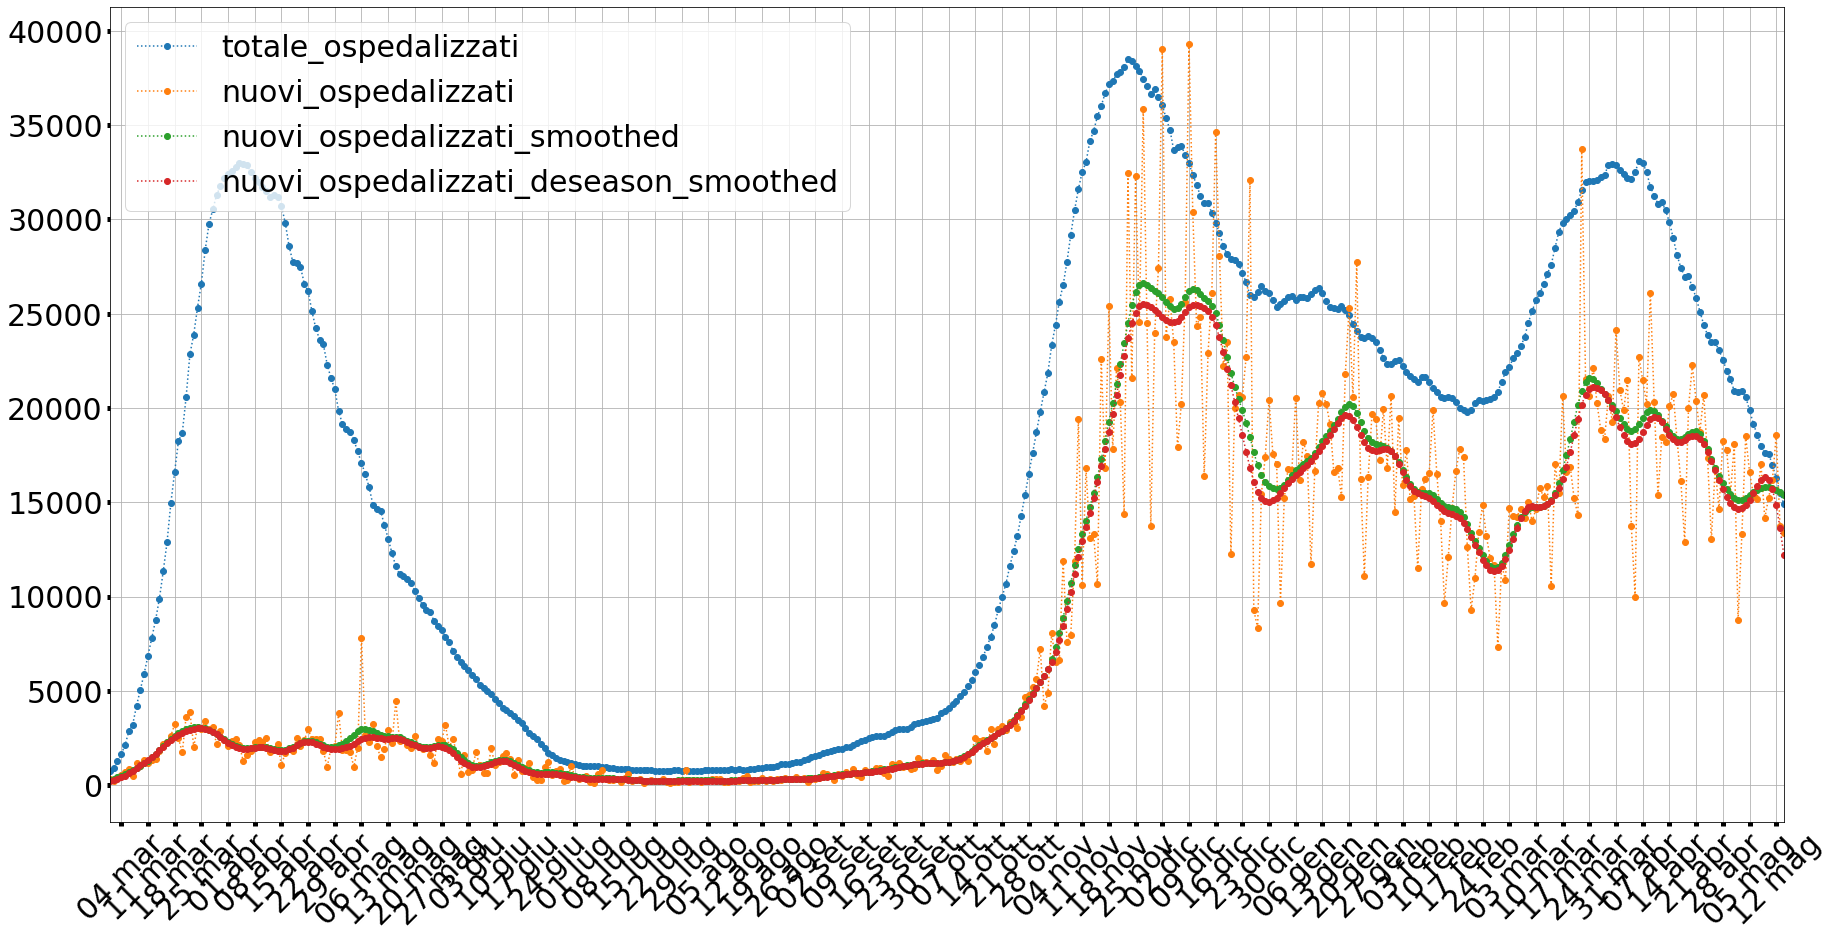

In [10]:
plotting.plot_series(
    df=DPC_data,
    yfields=[
        'totale_ospedalizzati',
        'nuovi_ospedalizzati', 
        'nuovi_ospedalizzati_smoothed',
        'nuovi_ospedalizzati_deseason_smoothed'
    ],
    #xlim=(datetime(2020,7,25), datetime(2020,10,1)),#DPC_data.data.max()),
    #ylim=(-1000,1000),
    xlim=(datetime(2020,3,1), DPC_data.data.max()),
    #ylim=(-10000,40000),
    legend_loc="upper left"
)

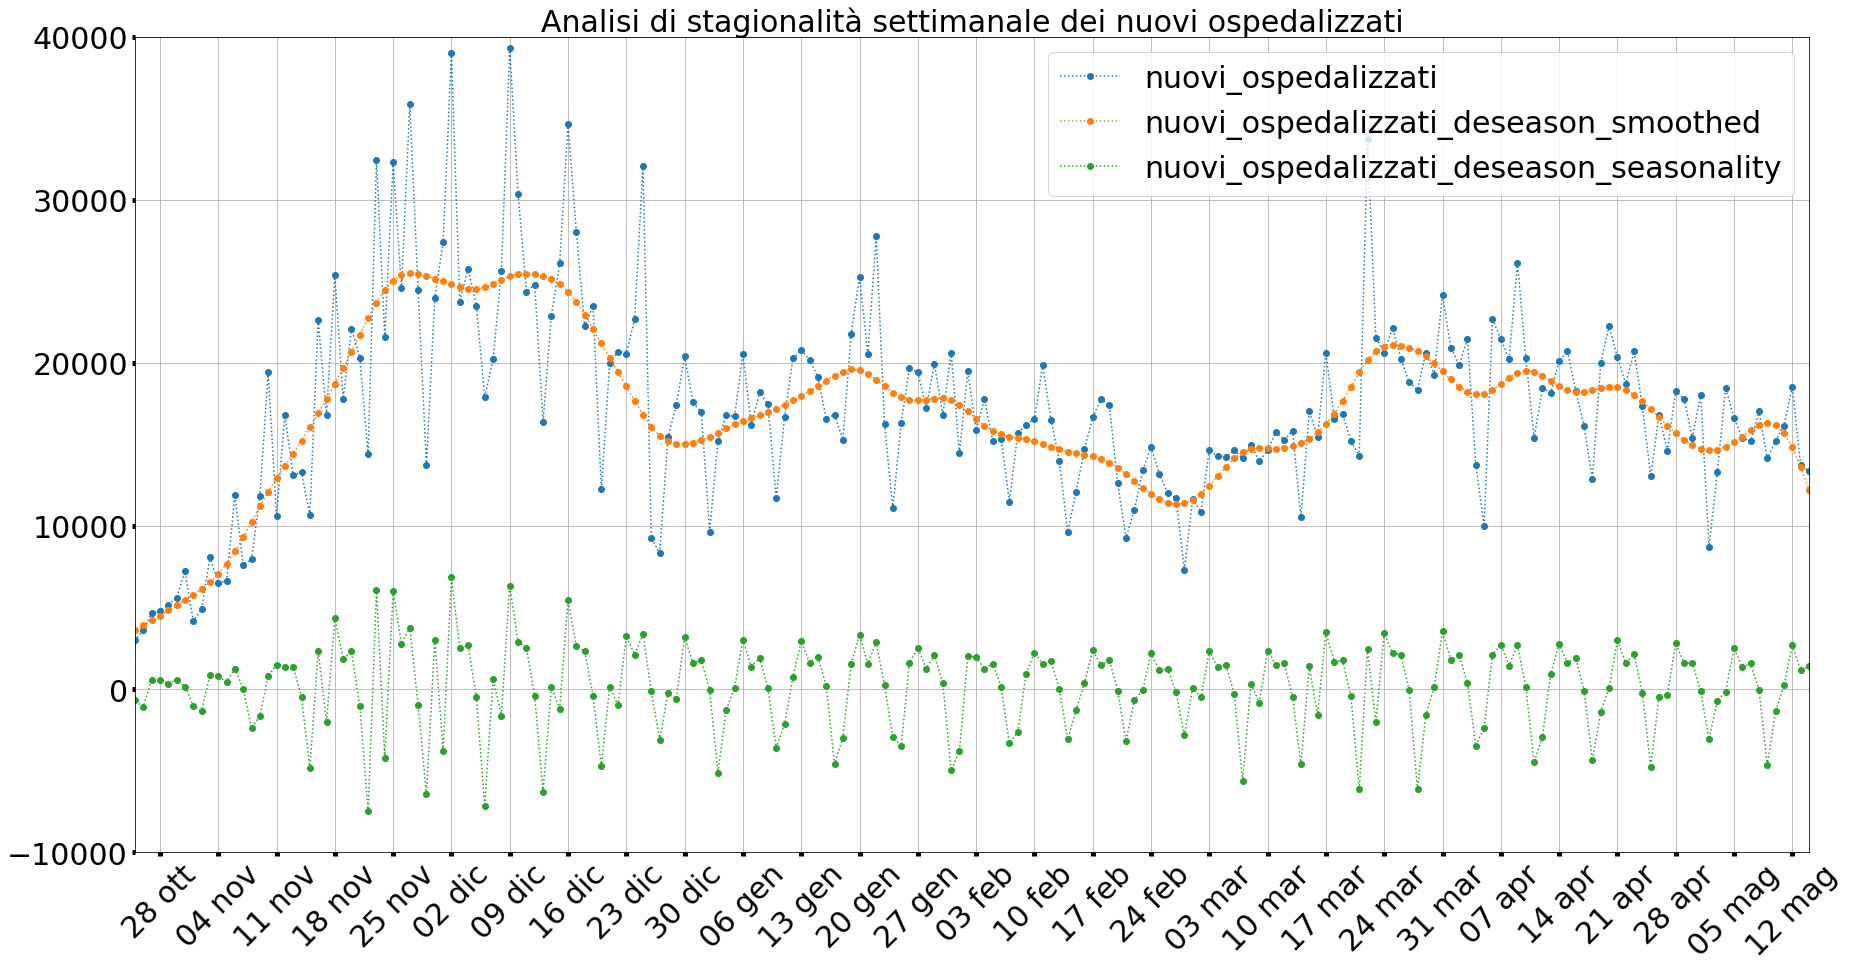

In [8]:
plotting.plot_series(
    title='Analisi di stagionalità settimanale dei nuovi ospedalizzati',
    data=[{
        'df': DPC_data,
        'xfield': 'data',
        'yfields':[
            'nuovi_ospedalizzati', 
            'nuovi_ospedalizzati_deseason_smoothed',
            'nuovi_ospedalizzati_deseason_seasonality'
        ],
    }],
    xlim=(datetime(2020,10,25), DPC_data.data.max()),
    ylim=(-10000,40000),
    #img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'italy/nuovi_casi'),
    legend_loc="upper right"
)

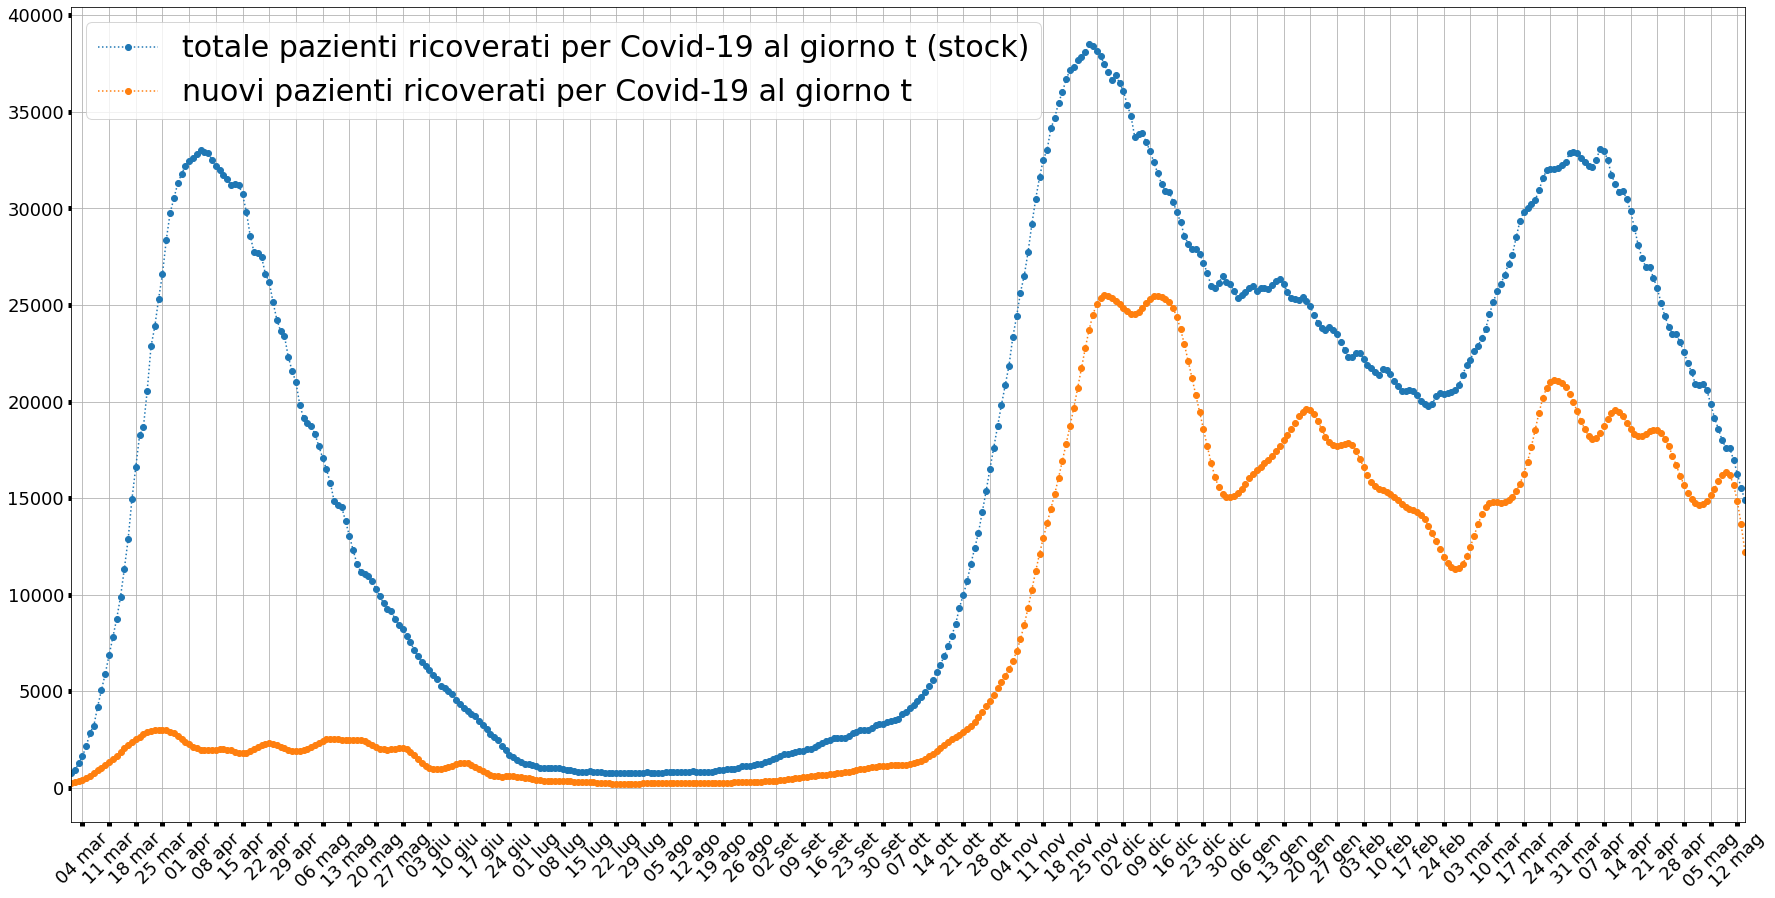

In [34]:
plotting.plot_series(
    data=[
        {
            'df': DPC_data,
            'yfields': [
                'totale_ospedalizzati',
                'nuovi_ospedalizzati_deseason_smoothed',
            ],
            'labels': [
                'totale pazienti ricoverati per Covid-19 al giorno t (stock)',
                'nuovi pazienti ricoverati per Covid-19 al giorno t'
            ],
        }
    ],
    #xlim=(datetime(2020,7,25), datetime(2020,10,1)),#DPC_data.data.max()),
    #ylim=(-1000,1000),
    xlim=(datetime(2020,3,1), DPC_data.data.max()),
    #ylim=(0,250000),
    legend_loc="upper left",
    tick_fontsize=18,
    img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH, 'italy/hospitalized_comparison'),
    quality=40,
)

# Residuals

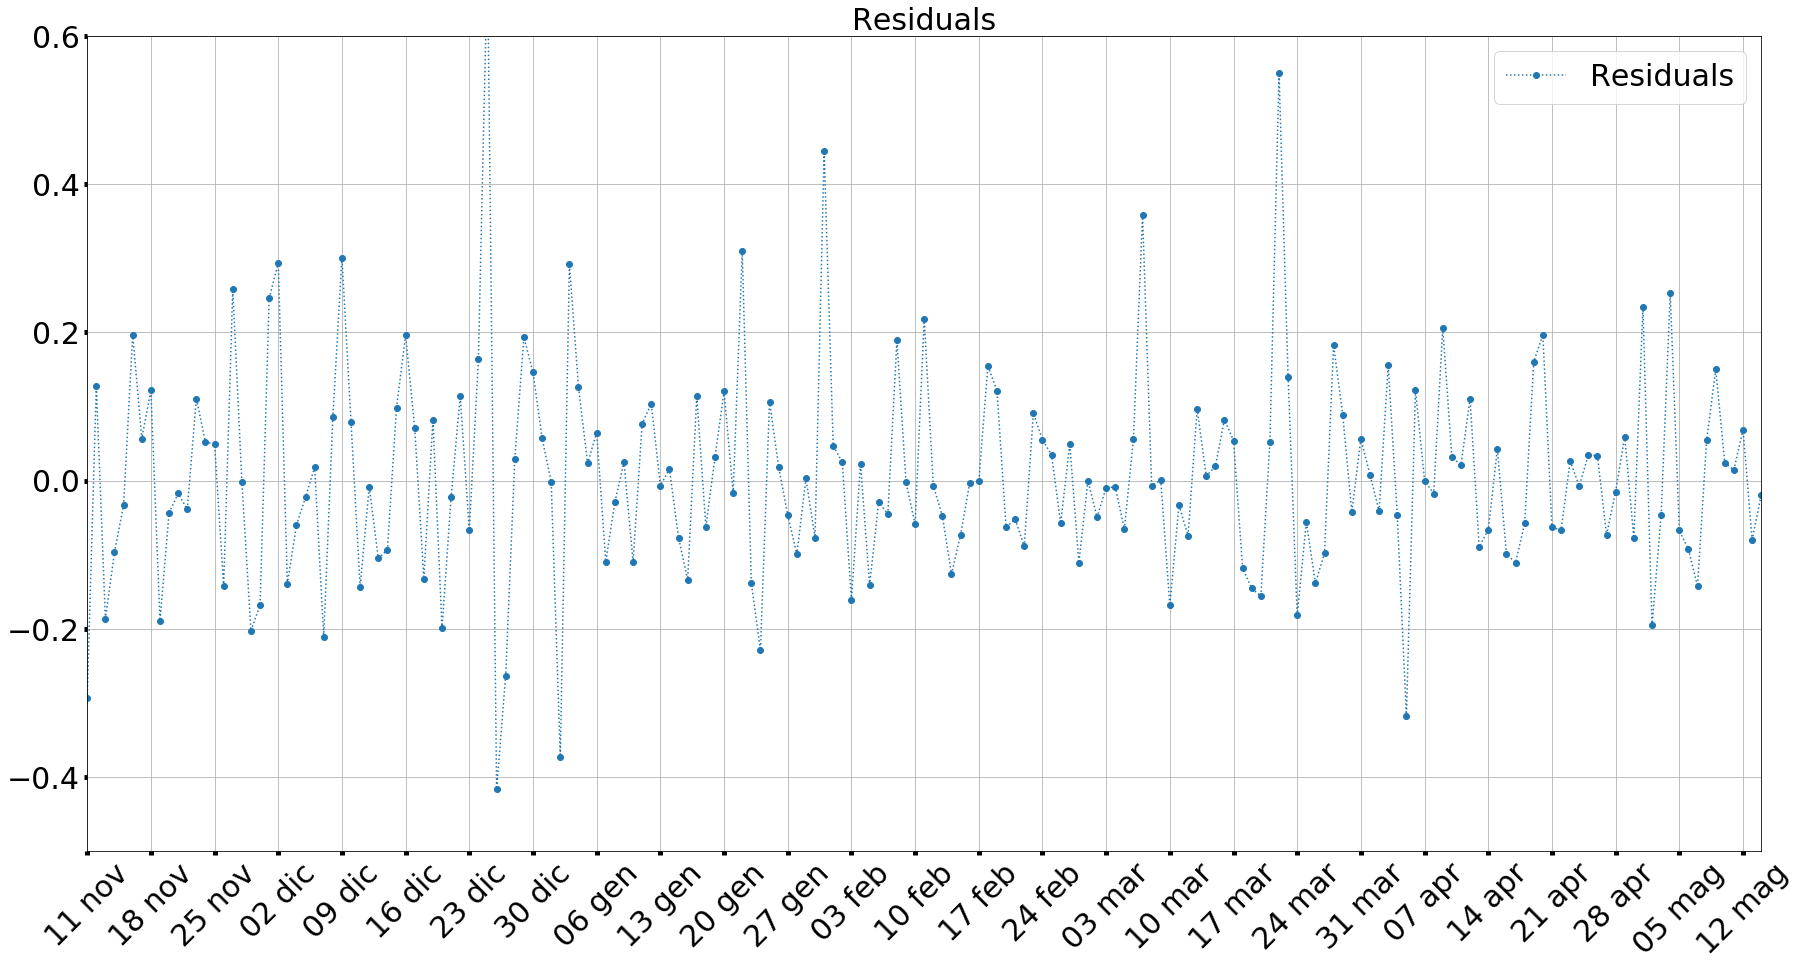

In [30]:
plotting.plot_series(
    title='Residuals',
    data=[{
        'df':DPC_data,
        'xfield': 'data',
        'yfields':[
            'nuovi_ospedalizzati_deseason_relative_residuals',
        ],
        'labels':[
            'Residuals',
        ]
    }],
    #img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'Rt_seasonality.{}'),
    xlim=(datetime(2020,11,11), DPC_data.data.max()),
    ylim=(-0.5,0.6),
    legend_loc="upper right"
)

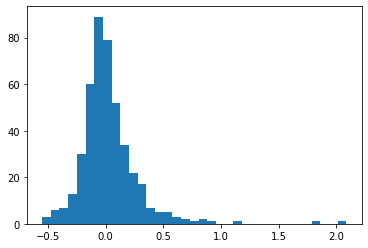

In [31]:
_=plt.hist(DPC_data.nuovi_ospedalizzati_deseason_relative_residuals,bins=35)